# BIOMAG introduction material 2. - Pytorch neural network basics

In [2]:
import torch # pytorch basic package
from torch import nn # neural net 
from torch.utils.data import DataLoader, Dataset # to work with data
from torchvision import datasets # built-in data
from torchvision.transforms import ToTensor # to convert nparrays/images into pytorch tensors
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [3]:
torch.manual_seed(0) # for reproducibility

First, let's check if the GPU is available:

In [3]:
torch.cuda.is_available()

/home/dhirling/venvs/detectron/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


False

Now, let us download the datasets that we are going to use:

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

The PyTorch ``DataLoader`` acts as a wrapper over the ``Dataset`` and supports batching, random sampling, augmentation, etc., basically everything you would need for your neural network research.

In [5]:
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


print(test_data[10][0].shape)
print(len(test_data))

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64
torch.Size([1, 28, 28])
10000


In [6]:
a = 5
print(labels_map[0])

T-Shirt


Let's see how a single sample from our test set looks like:

y[0] = tensor(9)
y[0].item() = 9
labels_map[y[0].item()] = 'Ankle Boot'


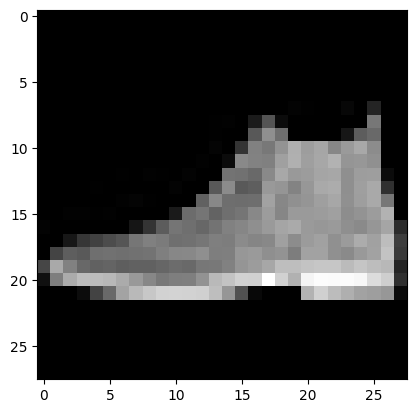

In [7]:
print(f'{y[0] = }')
print(f'{y[0].item() = }')
print(f'{labels_map[y[0].item()] = }')
plt.imshow(X[0,0,:,:], cmap='gray')
plt.show()

Now let us create our own neural network in PyTorch. for that, we need to create our own class, which inherits most of the properties from the ``nn.Module`` class.

In [6]:
# Set the GPU as the main device if it is available, if not, the CPU will suffice
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'We are using the following device: {device}')

We are using the following device: cuda


In [7]:
# Define model
class NeuralNetwork(nn.Module):
    # here we define the neural net layers
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # this flattens out any tensor, meaning a 28x28 matrix will become a 1D vector of 784
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features = 28*28, out_features = 512, bias = True), # this will do the standard wx + b perceptron operation and will set all parameters to be the correct shape.
            nn.ReLU(), # perform the relu activation (z = relu(wx + b))
            nn.Linear(in_features = 512, out_features = 512), # and so on... note that in_features has to match the previous layer's out_features size.
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = 10) # bias is set True by default.
        )

    # here we specify how the data will flow through the network.
    def forward(self, x):
        # first we flatten our input x, which is an image (why is thid good/bad?)
        x = self.flatten(x)
        # then we perform the network prediction with the sequential layers specified in the init function.
        logits = self.linear_relu_stack(x)
        # we return the prediction (what is the size?)
        return logits

In [8]:
# We create our model by instantiating the NeuralNetwork class and immediately move it to the GPU
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (class_layer): Linear(in_features=512, out_features=10, bias=True)
)


What happens if we apply our model on a batch of images from the training set?

In [11]:
X, y = next(iter(train_dataloader))
result = model(X) # apply the operations specified in the forward function: it's the same as model.forward(X)

Now we get a problem, because our network (``model``) is on a different device compared to the samples and labels ``X`` and ``y``. Let's move our samples and labels to the GPU as well:

In [12]:
X, y = X.to(device), y.to(device)
result = model(X)
print(f'{result.shape = }')

result.shape = torch.Size([32, 10])


So how does a prediction look like for a single image?

In [13]:
print(f'{result[0] = }')
print(f'{result = }')

result[0] = tensor([ 0.0197, -0.0620,  0.0220,  0.0378, -0.0451, -0.1791,  0.0351, -0.0829,
         0.0705,  0.0719], grad_fn=<SelectBackward0>)
result = tensor([[ 0.0197, -0.0620,  0.0220,  0.0378, -0.0451, -0.1791,  0.0351, -0.0829,
          0.0705,  0.0719],
        [-0.0386, -0.0509,  0.0750,  0.0098, -0.0814, -0.1424,  0.0469, -0.0179,
          0.1015,  0.0805],
        [ 0.0349, -0.0377,  0.0032, -0.0295, -0.0274, -0.0772, -0.0144, -0.0402,
          0.0345,  0.0515],
        [ 0.0272, -0.0477,  0.0416, -0.0280, -0.0298, -0.0924,  0.0086, -0.0159,
          0.0533,  0.0700],
        [ 0.0238, -0.0205,  0.0144, -0.0009, -0.0869, -0.1438,  0.0310, -0.0261,
          0.0545,  0.0866],
        [-0.0434, -0.0890,  0.0141,  0.0296, -0.0492, -0.1733,  0.0323, -0.0437,
          0.1334,  0.0964],
        [ 0.0111,  0.0043,  0.0252, -0.0052, -0.0317, -0.0965,  0.0144, -0.0835,
          0.0975,  0.0429],
        [-0.0276, -0.0723,  0.0383,  0.0382, -0.0584, -0.2195,  0.0668, -0.0396,
 

These values are essentially probabilities, so for example, ``result[0]`` will output 10 probability values for the 1st image in the batch, each telling us how likely it is that the image is from class ``n`` (where ``n`` goes from 0  to 9). An easy way to tell immediately which class got the highest probability:

In [14]:
print(result[0].argmax().item())
print(f' The predicted class for image 0 is: {labels_map[result[0].argmax().item()]}')


9
 The predicted class for image 0 is: Ankle Boot


### Training (and testing) the network
Do train a network, we need a loss function and an optimizer method:

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [18]:
# training procedure for a single epoch
def train(train_dataloader, model, loss_fn, optimizer):
    num_samples = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    model.train() # if we are in training mode, some functions will behave differently (e.g. dropout, batchnorm)

    training_loss = 0

    # iterate through the whole dataset, batch just stores the index of the batch.
    # if we have a total of 128 images, with a batch size of 32 we will have 4 batches before the for loop stops
    for batch, (X,y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # calc yhat and loss value
        yhat = model(X)
        loss = loss_fn(yhat, y)
        training_loss += loss.item()

        # backpropagation: calculate the partial derivatives for each neural net parameter
        loss.backward()
        # update neural network parameters according to the partial derivatives
        optimizer.step()
        # zero out the variables that are used for storing the gradients
        optimizer.zero_grad()

        # we ususally don't want to print information at every batch, so make it a bit more scarce:
        if batch % 100 == 0:
            current_loss = loss.item()
            current = (batch + 1) * len(X) # len(X) is the batch size
            print(f'{current}/{num_samples} : {current_loss = }')
    
    training_loss /= num_batches
    return training_loss

We also write a test function to see how the model works on the test set:

In [19]:
def test(epoch, test_dataloader, model, loss_fn):
    num_samples = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval() # if we are in eval mode, some functions behave differently
    test_loss = 0 
    correct = 0
    with torch.no_grad(): # we do not want to calculate gradients in eval mode
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y).item()
            test_loss += loss # we summarize the test loss across all batches
            correct_pred_locations = (pred.argmax(1) == y).type(torch.float) # also torch.argmax(pred, dim=1) is correct, and then we convert these locations to float
            correct += correct_pred_locations.sum().item() # we summarize how many items we got correct
    test_loss /= num_batches # we average the loss
    correct /= num_samples
    print(f'End of epoch {epoch+1}\n Accuracy: {(100*correct):.2f}%, Average loss: {test_loss:.4f}\n')
    return test_loss

Now let's do the actual training and evaluation:

In [20]:
epochs = 10
train_losses = []
test_losses = []
for t in tqdm(range(epochs)):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(t, test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

print("Done!")

  0%|          | 0/10 [00:00<?, ?it/s]

32/60000 : current_loss = 2.3179779052734375
3232/60000 : current_loss = 2.315708875656128
6432/60000 : current_loss = 2.2781155109405518
9632/60000 : current_loss = 2.25747013092041
12832/60000 : current_loss = 2.237417697906494
16032/60000 : current_loss = 2.242656946182251
19232/60000 : current_loss = 2.216090440750122
22432/60000 : current_loss = 2.1993987560272217
25632/60000 : current_loss = 2.1865286827087402
28832/60000 : current_loss = 2.137355089187622
32032/60000 : current_loss = 2.0907020568847656
35232/60000 : current_loss = 2.0432369709014893
38432/60000 : current_loss = 2.1589226722717285
41632/60000 : current_loss = 2.048189878463745
44832/60000 : current_loss = 2.001328229904175
48032/60000 : current_loss = 1.9996063709259033
51232/60000 : current_loss = 2.05395245552063
54432/60000 : current_loss = 1.9513449668884277
57632/60000 : current_loss = 1.8752305507659912


 10%|█         | 1/10 [00:08<01:13,  8.21s/it]

End of epoch 1
 Accuracy: 53.47%, Average loss: 1.8668

32/60000 : current_loss = 1.8575505018234253
3232/60000 : current_loss = 1.889259934425354
6432/60000 : current_loss = 1.8027961254119873
9632/60000 : current_loss = 1.7491294145584106
12832/60000 : current_loss = 1.688451886177063
16032/60000 : current_loss = 1.7650010585784912
19232/60000 : current_loss = 1.555234670639038
22432/60000 : current_loss = 1.5524206161499023
25632/60000 : current_loss = 1.5618681907653809
28832/60000 : current_loss = 1.5219999551773071
32032/60000 : current_loss = 1.3662418127059937
35232/60000 : current_loss = 1.3001668453216553
38432/60000 : current_loss = 1.5255181789398193
41632/60000 : current_loss = 1.3771802186965942
44832/60000 : current_loss = 1.2836493253707886
48032/60000 : current_loss = 1.2705013751983643
51232/60000 : current_loss = 1.3628780841827393
54432/60000 : current_loss = 1.3610389232635498
57632/60000 : current_loss = 1.173859715461731


 20%|██        | 2/10 [00:16<01:04,  8.02s/it]

End of epoch 2
 Accuracy: 63.21%, Average loss: 1.2359

32/60000 : current_loss = 1.2276357412338257
3232/60000 : current_loss = 1.228285551071167
6432/60000 : current_loss = 1.21071457862854
9632/60000 : current_loss = 1.2725032567977905
12832/60000 : current_loss = 1.1197423934936523
16032/60000 : current_loss = 1.3035635948181152
19232/60000 : current_loss = 0.9983610510826111
22432/60000 : current_loss = 1.0259754657745361
25632/60000 : current_loss = 1.093198299407959
28832/60000 : current_loss = 1.164613127708435
32032/60000 : current_loss = 0.9804417490959167
35232/60000 : current_loss = 0.9269165396690369
38432/60000 : current_loss = 1.2068864107131958
41632/60000 : current_loss = 1.0551934242248535
44832/60000 : current_loss = 0.9705529808998108
48032/60000 : current_loss = 0.9066712856292725
51232/60000 : current_loss = 1.015914797782898
54432/60000 : current_loss = 1.1309579610824585
57632/60000 : current_loss = 0.8860533237457275


 30%|███       | 3/10 [00:23<00:55,  7.96s/it]

End of epoch 3
 Accuracy: 65.67%, Average loss: 0.9711

32/60000 : current_loss = 0.9299236536026001
3232/60000 : current_loss = 0.9676246047019958
6432/60000 : current_loss = 0.951221764087677
9632/60000 : current_loss = 1.0933637619018555
12832/60000 : current_loss = 0.8693445920944214
16032/60000 : current_loss = 1.1038291454315186
19232/60000 : current_loss = 0.7648152112960815
22432/60000 : current_loss = 0.7866244316101074
25632/60000 : current_loss = 0.8866464495658875
28832/60000 : current_loss = 1.049747109413147
32032/60000 : current_loss = 0.803266167640686
35232/60000 : current_loss = 0.7557001709938049
38432/60000 : current_loss = 1.0955702066421509
41632/60000 : current_loss = 0.9429977536201477
44832/60000 : current_loss = 0.8536184430122375
48032/60000 : current_loss = 0.7539700865745544
51232/60000 : current_loss = 0.8629312515258789
54432/60000 : current_loss = 1.0233025550842285
57632/60000 : current_loss = 0.7703955173492432


 40%|████      | 4/10 [00:31<00:47,  7.92s/it]

End of epoch 4
 Accuracy: 67.54%, Average loss: 0.8518

32/60000 : current_loss = 0.7851779460906982
3232/60000 : current_loss = 0.8722217679023743
6432/60000 : current_loss = 0.8230079412460327
9632/60000 : current_loss = 0.9783138036727905
12832/60000 : current_loss = 0.7483274340629578
16032/60000 : current_loss = 1.0105066299438477
19232/60000 : current_loss = 0.651472806930542
22432/60000 : current_loss = 0.6581982970237732
25632/60000 : current_loss = 0.7800417542457581
28832/60000 : current_loss = 0.9948737621307373
32032/60000 : current_loss = 0.7192630767822266
35232/60000 : current_loss = 0.6716568470001221
38432/60000 : current_loss = 1.0326107740402222
41632/60000 : current_loss = 0.8997618556022644
44832/60000 : current_loss = 0.8062951564788818
48032/60000 : current_loss = 0.6777500510215759
51232/60000 : current_loss = 0.7789291739463806
54432/60000 : current_loss = 0.9540868401527405
57632/60000 : current_loss = 0.7151429653167725


 50%|█████     | 5/10 [00:39<00:39,  7.95s/it]

End of epoch 5
 Accuracy: 69.99%, Average loss: 0.7845

32/60000 : current_loss = 0.7012519240379333
3232/60000 : current_loss = 0.8291477560997009
6432/60000 : current_loss = 0.7394806146621704
9632/60000 : current_loss = 0.8871161341667175
12832/60000 : current_loss = 0.6761825084686279
16032/60000 : current_loss = 0.9587879180908203
19232/60000 : current_loss = 0.5896158218383789
22432/60000 : current_loss = 0.5771933197975159
25632/60000 : current_loss = 0.711334764957428
28832/60000 : current_loss = 0.9545825719833374
32032/60000 : current_loss = 0.679513156414032
35232/60000 : current_loss = 0.6233816146850586
38432/60000 : current_loss = 0.9789640307426453
41632/60000 : current_loss = 0.8786115646362305
44832/60000 : current_loss = 0.7783153653144836
48032/60000 : current_loss = 0.6302167773246765
51232/60000 : current_loss = 0.7212133407592773
54432/60000 : current_loss = 0.90023273229599
57632/60000 : current_loss = 0.6827230453491211


 60%|██████    | 6/10 [00:47<00:31,  7.96s/it]

End of epoch 6
 Accuracy: 72.55%, Average loss: 0.7378

32/60000 : current_loss = 0.6423658132553101
3232/60000 : current_loss = 0.8012318015098572
6432/60000 : current_loss = 0.6767279505729675
9632/60000 : current_loss = 0.8143655061721802
12832/60000 : current_loss = 0.6236092448234558
16032/60000 : current_loss = 0.9221161007881165
19232/60000 : current_loss = 0.5508206486701965
22432/60000 : current_loss = 0.5167889595031738
25632/60000 : current_loss = 0.6595560908317566
28832/60000 : current_loss = 0.9184271693229675
32032/60000 : current_loss = 0.6588608026504517
35232/60000 : current_loss = 0.5899806022644043
38432/60000 : current_loss = 0.9280648827552795
41632/60000 : current_loss = 0.8638541102409363
44832/60000 : current_loss = 0.7547705173492432
48032/60000 : current_loss = 0.5955496430397034
51232/60000 : current_loss = 0.6759569048881531
54432/60000 : current_loss = 0.8548617959022522
57632/60000 : current_loss = 0.659784197807312


 70%|███████   | 7/10 [00:55<00:23,  7.99s/it]

End of epoch 7
 Accuracy: 74.56%, Average loss: 0.7005

32/60000 : current_loss = 0.5967254638671875
3232/60000 : current_loss = 0.7772932052612305
6432/60000 : current_loss = 0.6264411211013794
9632/60000 : current_loss = 0.7566813230514526
12832/60000 : current_loss = 0.5810956954956055
16032/60000 : current_loss = 0.8913201689720154
19232/60000 : current_loss = 0.5225026607513428
22432/60000 : current_loss = 0.46688345074653625
25632/60000 : current_loss = 0.618460476398468
28832/60000 : current_loss = 0.8841698169708252
32032/60000 : current_loss = 0.6455210447311401
35232/60000 : current_loss = 0.5630003809928894
38432/60000 : current_loss = 0.8794153332710266
41632/60000 : current_loss = 0.8515462279319763
44832/60000 : current_loss = 0.7335138916969299
48032/60000 : current_loss = 0.567471444606781
51232/60000 : current_loss = 0.6389849185943604
54432/60000 : current_loss = 0.8159232139587402
57632/60000 : current_loss = 0.6414066553115845


 80%|████████  | 8/10 [01:03<00:15,  7.96s/it]

End of epoch 8
 Accuracy: 76.42%, Average loss: 0.6690

32/60000 : current_loss = 0.5602832436561584
3232/60000 : current_loss = 0.7546260952949524
6432/60000 : current_loss = 0.5854899287223816
9632/60000 : current_loss = 0.710845947265625
12832/60000 : current_loss = 0.5451810956001282
16032/60000 : current_loss = 0.8644978404045105
19232/60000 : current_loss = 0.5009932518005371
22432/60000 : current_loss = 0.42431867122650146
25632/60000 : current_loss = 0.5857078433036804
28832/60000 : current_loss = 0.8512700796127319
32032/60000 : current_loss = 0.6351916193962097
35232/60000 : current_loss = 0.5402008891105652
38432/60000 : current_loss = 0.8336632251739502
41632/60000 : current_loss = 0.8407769799232483
44832/60000 : current_loss = 0.715779185295105
48032/60000 : current_loss = 0.544330894947052
51232/60000 : current_loss = 0.6092020273208618
54432/60000 : current_loss = 0.7825528979301453
57632/60000 : current_loss = 0.6259620785713196


 90%|█████████ | 9/10 [01:11<00:07,  7.93s/it]

End of epoch 9
 Accuracy: 77.63%, Average loss: 0.6422

32/60000 : current_loss = 0.5321946740150452
3232/60000 : current_loss = 0.7336203455924988
6432/60000 : current_loss = 0.551207959651947
9632/60000 : current_loss = 0.67436283826828
12832/60000 : current_loss = 0.5146070718765259
16032/60000 : current_loss = 0.8417096138000488
19232/60000 : current_loss = 0.48419615626335144
22432/60000 : current_loss = 0.3878411054611206
25632/60000 : current_loss = 0.5592789649963379
28832/60000 : current_loss = 0.8194368481636047
32032/60000 : current_loss = 0.6254838109016418
35232/60000 : current_loss = 0.521005392074585
38432/60000 : current_loss = 0.7923542261123657
41632/60000 : current_loss = 0.8313308358192444
44832/60000 : current_loss = 0.7028661370277405
48032/60000 : current_loss = 0.5258781909942627
51232/60000 : current_loss = 0.5860700011253357
54432/60000 : current_loss = 0.7536707520484924
57632/60000 : current_loss = 0.6125257015228271


100%|██████████| 10/10 [01:19<00:00,  7.99s/it]

End of epoch 10
 Accuracy: 78.34%, Average loss: 0.6194

Done!


Now, let us plot the training and validation curves:

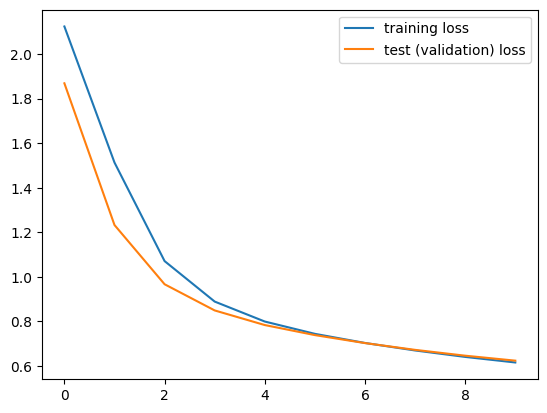

In [23]:
plt.plot(train_losses, label="training loss")
plt.plot(test_losses, label="test (validation) loss")
plt.legend()
plt.show()

Let us save this model for further use:

In [9]:
torch.save(model.state_dict(), "mnist_starter_model.pth")

If we want to load it later:

In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("mnist_starter_model.pth"))

<All keys matched successfully>

Do a quick visual evaluation:

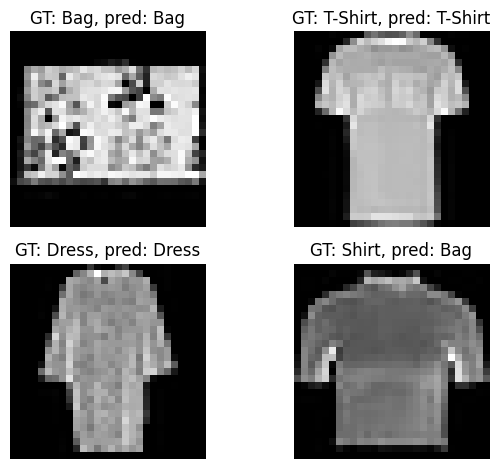

In [26]:
model.eval()
indices = np.random.randint(len(test_data), size=(4)) # pick 4 random images from the test set
f = plt.figure()
for fig_idx, i in enumerate(indices):
    x, y = test_data[i][0], test_data[i][1]
    x = x.to(device)
    pred_vector = model(x)
    pred_value = labels_map[pred_vector.argmax().item()]
    gt_value = labels_map[y]
    plt.subplot(2,2,fig_idx+1)
    plt.title(f'GT: {gt_value}, pred: {pred_value}')
    plt.imshow(x.cpu()[0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Homework
1. Try training the network for a longer time. What can you observe in terms of training and validation losses? Why do you think this is the case?
2. Try tweaking the network parameters (number of neurons, number of layers, etc) to reach a better accuracy than the original model after 10 epochs.
3. Modify the network so that if you save the weights after training and you reload reload these weights, you can later adjust the model parameters for fewer/more classes